This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import itertools
import os
import pickle

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.preprocessing import StandardScaler

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data = pd.read_csv("../Data/OriginalSimulatedData.csv")

In [3]:
train_data

,churn,amount_spent,num_visits,age,hiking_int,sustain_int,online_int,id
0,0,1530.870475,74,38,1,1,1,1001
1,1,666.063376,30,62,0,0,1,1002
2,0,1267.314885,84,32,1,1,0,1003
3,1,526.444234,33,83,0,0,1,1004
4,0,1162.169420,35,79,1,1,1,1005
...,...,...,...,...,...,...,...,...
9995,0,1207.401064,59,49,0,1,1,10996
9996,0,1316.129175,51,46,0,1,1,10997
9997,0,1301.845746,70,50,0,1,1,10998
9998,0,1212.640058,56,61,1,1,0,10999


In [3]:
train_data = train_data.drop('id', axis=1)

In [4]:
train_data

,churn,amount_spent,num_visits,age,hiking_int,sustain_int,online_int
0,0,1530.870475,74,38,1,1,1
1,1,666.063376,30,62,0,0,1
2,0,1267.314885,84,32,1,1,0
3,1,526.444234,33,83,0,0,1
4,0,1162.169420,35,79,1,1,1
...,...,...,...,...,...,...,...
9995,0,1207.401064,59,49,0,1,1
9996,0,1316.129175,51,46,0,1,1
9997,0,1301.845746,70,50,0,1,1
9998,0,1212.640058,56,61,1,1,0


***

Functions for logistic and multinomial logistic regression synthesizer.

In [6]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_hiking_int,
                    C_sustain_int,
                    C_online_int):
    
    num_samples = train_data.shape[0]

    # normalized version of training data
    scaler = StandardScaler().fit(train_data.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
    norm_train = train_data.copy()
    norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, covariance_type='full', init_params="k-means++", random_state=rng).fit(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX, columns=['amount_spent', 'num_visits', 'age', 'churn'])
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for hiking_int MN ##########
    
    synth_hiking_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']], 
                                                   synth_data_sets=sXs, 
                                                   target=norm_train.hiking_int, 
                                                   penalty_param=C_hiking_int)
    print("After synthesis:", synth_hiking_int_vars[i].std())
    sXs = [pd.concat([Y, synth_hiking_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]  

    ####################################################################################################
        
    ########### Code for sustain_int MN ##########
    
    synth_sustain_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'hiking_int', 'churn']], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.sustain_int, 
                                             penalty_param=C_sustain_int)
    print("After synthesis:", synth_sustain_int_vars[i].std())
    sXs = [pd.concat([Y, synth_sustain_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]
    
    ####################################################################################################

    ########### Code for online_int MN ##########
    
    synth_online_int_vars = multinomial_synthesizer(orig_data=norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'hiking_int', 'sustain_int', 'churn']], 
                                             synth_data_sets=sXs, 
                                             target=norm_train.online_int, 
                                             penalty_param=C_online_int)
    print("After synthesis:", synth_online_int_vars[i].std())
    sXs = [pd.concat([Y, synth_online_int_vars[i]], axis=1) for i,Y in enumerate(sXs)]
     
    ####################################################################################################
        
    ###### Calculate pMSE ratios ######
    pmse_ratios = [pmse_ratio(norm_train, Y) for Y in sXs]

    # convert sXs to original scale (un-normalize?)
    for i, Z in enumerate(sXs):
        H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['amount_spent', 'num_visits', 'age', 'churn']]
        scaler = StandardScaler().fit(H)
        Z.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.inverse_transform(Z.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
        Z.loc[:, ['age']] = np.round(Z.loc[:, ['age']], 0)
        Z.loc[:, ['num_visits']] = np.round(Z.loc[:, ['num_visits']], 0)   
    print("pmse_ratios:", pd.Series(pmse_ratios).isna().sum())
    print("sXs:", pd.Series(sXs).isna().sum())
    print("GMM:", pd.Series(GMM).isna().sum())
    return pmse_ratios, sXs, GMM

In [7]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_hiking_int, C_sustain_int, C_online_int):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_hiking_int=C_hiking_int,
                                            C_sustain_int=C_sustain_int,
                                            C_online_int=C_online_int)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (10, 200.99),
            "C_hiking_int": (0.001, 3),
            "C_sustain_int": (0.001, 3),
            "C_online_int": (0.001, 3)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [8]:
nsd = 10
ngi = 2
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [ ]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]
print("done")

In [17]:
optimization_results

[({'target': np.float64(-1082.8869261198774),
   'params': {'C_hiking_int': np.float64(3.0),
    'C_online_int': np.float64(0.001),
    'C_sustain_int': np.float64(3.0),
    'num_components_': np.float64(180.21971644273543)}},
  <bayes_opt.bayesian_optimization.BayesianOptimization at 0x12ee657f0>),
 ({'target': np.float64(-904.7022656224602),
   'params': {'C_hiking_int': np.float64(2.2246186713231895),
    'C_online_int': np.float64(0.012809388759978335),
    'C_sustain_int': np.float64(2.2706444928362375),
    'num_components_': np.float64(88.79723031285305)}},
  <bayes_opt.bayesian_optimization.BayesianOptimization at 0x12ee0b110>)]

In [21]:
optimized_datasets = []

for r in random_states:
    best_result, optimizer = optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r)
    
    best_params = best_result['params']
    
    # Run train_models_mn again with best params to get the synthetic datasets
    pmse_ratios, sXs, GMM = train_models_mn(
        train_data=train_data,
        number_synthetic_datasets=nsd,
        number_gmm_initializations=ngi,
        num_components_=int(best_params['num_components_']),
        C_hiking_int=best_params['C_hiking_int'],
        C_sustain_int=best_params['C_sustain_int'],
        C_online_int=best_params['C_online_int']
    )
    
    optimized_datasets.append(sXs)


|   iter    |  target   | C_hiki... | C_onli... | C_sust... | num_co... |
-------------------------------------------------------------------------


/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46441950707076757


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4968109520856109


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4639790595024367
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.001163     -0.476786    0.050329 -0.481876           0            0   
19996  0.998143     -0.579747   -0.683253  0.721515           0            0   
19997  1.000080     -0.189666   -0.129603 -0.186463           1            0   
19998  0.998137     -0.330213    0.051219 -0.264757           0            0   
19999  1.001653     -0.350529   -0.516714 -0.119174           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4632924065699745


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49593765275036494


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4556147039723889
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.997830      0.631896    0.982475 -1.168735           1            1   
19996 -0.999801      1.065270    1.505905 -1.204915           1            1   
19997 -0.999789      0.573009    0.949527 -1.410187           1            1   
19998 -1.001145      0.508691    0.674523 -1.304511           1            1   
19999 -1.000150      0.555684    0.936477 -1.210903           1            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46393886873961393


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4984463410192591


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4616480281450241
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.998802     -1.496002   -0.639702  1.099195           0            0   
19996  1.001078     -1.520215   -0.831072  0.983861           0            0   
19997  1.001609     -1.007848   -0.665413  1.210686           0            0   
19998  1.000163     -1.208377   -0.658095  1.368350           0            0   
19999  0.999409     -1.450775   -0.746046  0.996001           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.45932051721401845


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49766707471132265


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.46445939785219686
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000039      0.635137    1.237269 -0.793943           1            0   
19996  0.998492      0.725407    0.961403 -0.895324           1            1   
19997  1.001510      0.620251    1.270616 -0.910283           1            0   
19998  1.000411      0.325919    1.049508 -1.007107           0            1   
19999  0.999624      0.363231    0.998083 -1.227164           1            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4575788214480472


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49694620991970073


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4662674989081416
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000565     -0.138511   -1.714340  1.764569           0            1   
19996 -0.999527     -0.188248   -1.267764  1.522778           0            1   
19997 -0.999865     -0.419051   -1.986008  1.791921           0            1   
19998 -1.002221      0.297112   -0.945082  0.603770           0            1   
19999 -1.001235     -0.008870   -1.828949  2.234649           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4594494742427487


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4962033169711558


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4762320019611967
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.001433     -1.110048    0.691271 -1.070862           0            0   
19996  1.000402     -1.225782    0.121755 -1.039348           0            0   
19997  1.000069     -1.471036    0.005724 -1.378438           1            0   
19998  0.999842     -0.746375    0.117111 -0.700487           0            0   
19999  1.000673     -1.790426    0.479820 -1.288174           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46168963138841784


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49684504173791444


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3334371875418271
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.997741     -0.330416   -1.501157  1.692293           0            1   
19996 -1.000920     -0.184855   -1.457127  1.974871           0            1   
19997 -0.999514     -0.474486   -1.664826  1.998541           0            1   
19998 -0.999103     -0.187474   -1.689718  1.948232           0            1   
19999 -1.000094     -0.139446   -1.501561  2.043432           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46173120922345834


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4961031766036009


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.34322998220153816
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999944      0.891480   -0.063408  0.528557           0            1   
19996 -1.001834      0.809419   -1.034258  0.601460           1            1   
19997 -0.999683      0.905263   -0.627049  1.468238           1            1   
19998 -0.998312      0.898145   -0.855577  0.614563           1            1   
19999 -1.001066      0.697391   -1.245768  0.873391           1            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.466653636610341


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4977539712564734


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.33730782329611875
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999260      0.541713    0.540184 -1.110536           0            1   
19996 -1.000458      0.391285    1.352759 -1.198596           0            1   
19997 -0.998590      0.307364    1.173631 -1.418530           1            1   
19998 -1.000285      0.800754    1.147013 -1.116154           1            1   
19999 -0.999364      0.154870    1.130612 -1.371328           1            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46043045036135694


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49650781665669685


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3299399885427712
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999368      0.830349    1.233930 -1.232272           1            1   
19996 -1.000059      0.575476    1.992119 -1.380719           1            1   
19997 -0.999956      0.948187    0.769373 -1.125486           1            1   
19998 -0.999647      0.324723    1.394593 -1.527513           1            1   
19999 -1.000640      0.730250    1.210967 -1.204793           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4638181461815317


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4965907875112305


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4641395722778391
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000710      0.148997   -1.351544  1.805514           1            1   
19996  1.000197     -0.022338   -1.629817  2.131733           0            1   
19997  0.999956     -0.178495   -1.638824  1.865730           0            1   
19998  0.999634     -0.390425   -1.635261  1.905363           0            1   
19999  0.999618     -0.673011   -1.852389  2.125909           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4654485731393144


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49700170127385573


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3320912351430641
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999251      2.008498   -0.483988  0.028590           1            1   
19996 -0.998984      1.687533   -0.320750 -0.131626           1            1   
19997 -0.998804      1.506212   -0.105454 -0.321910           1            1   
19998 -0.999420      1.864109   -0.346091 -0.318626           0            1   
19999 -1.000292      1.585868   -0.099344 -0.466546           1            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46481729261243193


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4967652137255152


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47548976755752087
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.001065      1.230645    0.834298  0.057450           1            1   
19996 -1.000828      1.116236    0.216125 -0.195474           1            1   
19997 -0.998867      0.982117    0.093057  0.228627           0            1   
19998 -0.999344      0.972989    0.014815  0.083505           0            1   
19999 -1.000391      0.784396    0.175873  0.237167           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46345462455228764


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4978951495626321


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.46521258825963374
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000040      1.061351    0.671351 -0.186113           1            1   
19996  1.000396      1.066934    0.792050 -0.004174           0            0   
19997  1.000304      1.079017    0.885896 -0.569951           0            0   
19998  0.998944      1.243168    0.698115 -0.434487           0            1   
19999  1.001113      0.965750    0.300682 -0.390825           1            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46599573517632137


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4903264647193749


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.33621019278030956
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999150      0.940105    0.333156 -0.171917           0            0   
19996 -1.001234      0.942991    0.381353 -0.114243           0            1   
19997 -1.000342      0.931703    0.394872  0.238061           0            0   
19998 -1.000663      1.109596    0.367372  0.043904           0            1   
19999 -0.998761      0.891913    0.519333  0.147357           1            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46349511623346934


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4964479389176729


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3335489101879195
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999013     -1.337911   -0.635832  1.129362           0            0   
19996  1.000404     -1.023896   -0.401281  0.892075           0            0   
19997  1.000983     -1.155735   -1.210493  1.292969           0            0   
19998  0.998930     -1.101628   -0.454939  0.919414           0            0   
19999  1.000330     -1.203169   -0.729225  1.134609           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4636971980820576


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49854047404441104


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3351059826412537
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000986      0.819833    1.579379 -0.598091           0            0   
19996  1.000753     -0.354490    1.192333 -1.397044           1            0   
19997  1.001641      0.164706    1.069367 -0.609217           1            0   
19998  1.000992      1.291026    1.089982 -0.375153           0            0   
19999  1.000223      1.243452    1.091896 -0.260998           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.461356093429462


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49650781665669685


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4660735054165223
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.002758      1.818023    0.709964 -0.625889           1            1   
19996 -0.999735      1.865667    0.230395  0.127639           1            1   
19997 -0.998577      1.795004    0.033144  0.153385           1            1   
19998 -0.998629      1.734001    0.400486 -0.110421           1            1   
19999 -0.999760      1.816665   -0.116597  0.143030           1            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4654485731393144


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49685636417848417


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4798192708231562
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999737      0.069632    0.618300 -0.068180           1            0   
19996  0.999579     -0.223374    0.075807 -0.064253           0            0   
19997  0.999797     -0.078510    0.527703 -0.170840           0            0   
19998  1.000620     -0.523414    0.429496  0.119608           0            0   
19999  1.000188      0.174244    1.025291 -0.484401           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4631704790779189


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4971865640259648


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.41891353386454994
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.001706     -1.649211   -2.289177  2.334761           0            0   
19996  0.999541     -1.687129   -1.642446  1.702638           0            0   
19997  1.000451     -1.338518   -1.910264  1.179779           0            0   
19998  0.999801     -1.881647   -1.733173  1.763409           0            0   
19999  0.998235     -2.047350   -2.177224  2.095866           0            0   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4619387175133448


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49786727868250014


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3901716716950877
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999472     -0.365640    0.554827 -0.987084           0            1   
19996 -0.999319     -0.904963    1.683538 -1.517978           1            0   
19997 -0.997937     -0.486405    0.193311 -0.775278           0            1   
19998 -1.000882      0.046300    0.191551 -0.868049           0            1   
19999 -0.999054     -0.094545    0.065702 -0.612011           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4619801430421621


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49645995533247683


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.33632025084896855
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000196      1.887779    0.457020 -0.313464           1            1   
19996 -0.999696      2.035028    1.079009 -0.545454           1            1   
19997 -1.000425      1.991006    0.894679 -0.306969           1            1   
19998 -0.999688      1.760624    0.604486 -0.453620           0            1   
19999 -1.000618      2.043087    0.368451 -0.174033           1            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46173120922345834


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.497121990086239


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.466999056542817
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999417      0.843011    0.446255  0.115039           0            0   
19996  1.000244      0.715680    0.840586  0.482821           0            0   
19997  0.999850      0.821789    0.640894  0.487833           1            1   
19998  0.999544      0.940065    0.531958  0.134875           0            0   
19999  0.999226      0.745346   -0.077546 -0.599989           0            1   

    

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4653700107706689


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4956762345452416


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3382901181240771
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.998159     -0.771691   -2.332536  2.318565           0            1   
19996 -0.998832     -0.508209   -2.269615  1.980884           0            1   
19997 -1.000123     -0.229609   -2.180045  1.206094           0            1   
19998 -1.000299     -0.287171   -2.185449  1.417794           0            1   
19999 -1.000091     -0.380413   -2.326406  1.651242           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.462434151565878


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49684504173791444


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3382901181240771
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999734     -0.853603    1.752247 -1.098909           0            0   
19996  1.001944     -0.548545    1.774263 -1.071975           1            0   
19997  1.001447     -1.310954    1.724283 -1.444606           1            0   
19998  1.001596     -0.729502    1.689817 -1.029862           1            0   
19999  0.999269     -0.987449    1.640967 -1.270426           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4616480281450241


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4991420882698916


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.33643024318698384
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.001966     -1.193491    1.329556 -1.257526           0            1   
19996  0.999224     -1.489207    1.085177 -1.203585           0            0   
19997  0.999704     -1.551116    0.974714 -1.210022           1            0   
19998  1.000687     -1.490757    1.088009 -1.313935           0            1   
19999  1.001141     -1.130644    0.949532 -1.376872           1            0   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4619387175133448


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4962033169711557


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.33980774995678525
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999253      0.751309   -0.029273 -0.006577           0            1   
19996 -0.998664      1.214307   -0.014551  0.172848           0            1   
19997 -0.999970      0.981428   -0.054238  0.136455           0            1   
19998 -1.000024      0.970558    0.055428  0.064275           0            1   
19999 -0.998777      1.152730    0.152789 -0.046429           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4640994816123836


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4957159705237902


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4667689978241196
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000307      0.109120    2.220278 -1.371849           0            1   
19996 -0.998814     -0.177915    1.829118 -1.093013           0            1   
19997 -1.001945      1.145610    1.816797 -1.327994           1            1   
19998 -1.000429     -0.140406    2.218110 -1.262165           1            0   
19999 -1.000304      0.373307    1.706292 -1.205510           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.463089068267126


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4977539712564734


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3346624417155135
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999411      0.842970    0.485249 -0.408549           0            0   
19996  0.999553      1.163565    0.311197 -0.323595           0            0   
19997  0.999397      1.010619    0.626151  0.092302           1            1   
19998  0.999884      1.238062    0.497945  0.260345           1            1   
19999  1.000531      1.045751    0.149107  0.056160           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4633329987673819


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4912235438748897


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.33980774995678525
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999557     -1.022803   -1.045196  0.940164           0            0   
19996  0.999391     -1.316747   -1.358714  0.783729           0            1   
19997  1.001797     -1.384957   -1.219553  0.759880           0            1   
19998  0.999220     -1.245380   -1.200012  1.090190           0            0   
19999  0.999744     -1.390763   -1.127189  0.357715           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4634951162334693


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49632665051798447


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3352167015882448
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999549      1.364305    1.301795 -1.054046           1            1   
19996 -1.000550      1.041129    1.374082 -1.155314           1            1   
19997 -1.000031      0.855684    1.615422 -1.211603           1            1   
19998 -1.000095      0.745656    1.570326 -1.333050           1            1   
19999 -1.000044      0.657868    0.548580 -1.193376           1            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46481729261243193


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49647195131230126


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4761679468332146
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000433      0.269956   -0.939628  0.842444           0            1   
19996 -0.998609     -0.159073   -1.135548  1.231860           0            1   
19997 -1.000356      0.127979   -1.308149  0.806911           0            1   
19998 -1.000805      0.011475   -0.668893  0.965639           0            1   
19999 -1.000383      0.538239   -0.765469  1.324642           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.459920332961337


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4965671836688261


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4664608757172004
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.001793     -0.398643   -1.535517  1.411558           0            0   
19996  0.999351     -0.190248   -0.855140  1.799110           0            1   
19997  1.000304     -0.259832   -1.226078  1.220062           0            0   
19998  0.999804     -0.227455   -1.015539  1.486690           1            1   
19999  1.001305     -0.625252   -1.974781  1.648960           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46013333096856485


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49606528610335926


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4663835989463358
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000131      1.212138    0.274400 -0.106334           0            1   
19996  1.000630      1.164714    0.840430 -0.388576           0            1   
19997  0.998630      0.927910    0.144820  0.041587           0            1   
19998  0.998805      1.211623    0.526922 -0.444018           0            1   
19999  0.999594      1.020865   -0.032232  0.103698           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4620629180252636


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4969350505291858


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.46441950707076757
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000727      0.373423   -0.068427  0.653300           0            1   
19996 -0.999636      0.546523   -0.289051  0.898535           0            1   
19997 -1.000090      0.112246   -0.363816  0.711865           0            1   
19998 -1.000549      0.442578   -0.111599  0.793765           0            1   
19999 -1.001360      0.697493    0.287686  0.679104           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4618142886959264


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49686766623294654


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47379996690677817
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999389      0.588837    0.869303 -0.510542           0            0   
19996  0.999702     -0.226660    0.891761 -0.901253           0            0   
19997  0.999995      0.020036    0.775608 -0.606843           1            0   
19998  0.999904      0.060452    0.740423 -0.732619           1            0   
19999  1.001270      0.123562    0.712602 -0.951137           1            0   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46272147250382883


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49797766835051704


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.466960774837163
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000268      1.713154    1.495984 -0.841075           1            1   
19996 -1.000267      1.746052    0.964279 -0.460620           1            1   
19997 -1.000478      1.279646    0.836782 -0.955265           1            1   
19998 -0.999660      1.557559    1.448603 -0.677827           1            1   
19999 -1.001542      2.055753    0.449430 -0.280542           1            1   

    

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4621042674931747


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49673069578838575


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4764872968027599
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.999156     -0.954208    0.595301 -1.533568           0            1   
19996 -1.000317     -0.299943    0.686435 -1.496170           0            1   
19997 -0.999291     -0.519207    0.747051 -1.483352           1            1   
19998 -0.999792     -0.110765    0.676560 -1.538904           1            1   
19999 -0.997506     -0.194051    0.920571 -1.570979           1            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4625574406909847


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4911664019896356


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.3334371875418271
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.998214     -0.353182   -1.826670  1.901205           0            1   
19996 -0.998380     -0.184638   -1.462357  2.036583           1            0   
19997 -1.000886     -0.297019   -1.466991  2.032063           0            1   
19998 -1.000182     -0.188680   -1.806605  1.631671           0            1   
19999 -0.999445     -0.352179   -1.493159  2.069732           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.462885100496469


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4970566834221762


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4795839343378878
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000551      0.188709    0.963401 -1.415809           1            1   
19996 -1.000414      0.227399    0.828062 -1.336957           0            1   
19997 -1.000960      0.009140    1.155987 -1.280916           0            1   
19998 -1.001735     -0.255080    1.398539 -1.462062           1            1   
19999 -1.000818     -0.180503    1.473327 -1.546274           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4621042674931747


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4940757037945785


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.45664774467446084
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.001693      1.422070    0.934947 -0.935469           0            1   
19996 -1.001543      0.860300    0.699106 -0.976711           0            1   
19997 -1.000449      0.481177    0.262805 -1.219333           0            1   
19998 -0.999135      0.635227    0.250747 -1.183037           0            1   
19999 -0.998903      0.460572    0.511423 -1.086015           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46461871147716977


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49380808482897903


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.46429968492315604
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000315      0.765710   -0.918198  1.249741           0            1   
19996 -0.998949      0.659158   -1.310484  1.302190           1            1   
19997 -1.000447      1.164748   -0.295482  0.532821           1            1   
19998 -1.000249      0.848845   -1.122080  1.118974           1            1   
19999 -1.000435      0.658290   -0.931719  1.083664           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4626805024255209


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49728205170093803


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47490030851780146
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000863      1.171232   -0.608713  0.032951           0            1   
19996 -1.000030      0.892866   -0.586306 -0.271410           1            1   
19997 -1.000155      1.022823   -0.536632 -0.234480           1            1   
19998 -0.999140      1.151337   -0.055869 -0.132358           1            1   
19999 -0.999571      0.616556   -0.453775 -0.667922           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4625574406909847


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4966377501816496


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.466960774837163
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999520     -1.168765   -0.926403  0.891458           0            0   
19996  0.998179     -1.401594   -0.822141  0.367099           0            0   
19997  0.997391     -1.339478   -0.713150  0.655018           0            0   
19998  0.998333     -1.167613   -0.645580  0.473656           0            0   
19999  0.997766     -1.184312   -0.904468  0.679172           1            0   

    

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46214559162106644


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4991181241852364


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4629667631940572
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -0.998901      1.740905    1.076699 -0.117506           0            1   
19996 -1.000956      1.464079    0.921182 -0.025908           0            1   
19997 -1.001000      1.704577    1.339245 -0.671916           1            1   
19998 -1.000634      1.838511    1.159708 -0.462404           1            1   
19999 -1.000464      1.897970    1.195432 -0.596050           1            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46013333096856485


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49678812369458314


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47197909532800564
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000803      0.060319   -1.999295  1.584081           0            1   
19996 -0.998625     -0.473900   -1.687648  1.332500           0            1   
19997 -0.999875      0.238806   -1.363737  1.429572           1            1   
19998 -1.000976     -0.346734   -1.307922  1.672358           0            1   
19999 -0.999272     -0.072815   -1.157740  1.622351           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46239300462817656


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49748835108567774


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4547964863369092
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999872      0.175003   -1.193997  0.694024           0            0   
19996  1.001723      0.016842   -1.203624  0.919340           0            0   
19997  0.999278     -0.100836   -0.722011  0.009584           0            0   
19998  0.998754     -0.099284   -1.241028  0.951238           0            1   
19999  0.999516      0.097663   -0.908907  0.160784           1            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4636971980820576


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49839818426134697


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47410259156297885
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.001173      0.199581    0.374385 -1.155587           0            1   
19996 -0.999394      0.463400   -0.069947 -0.877623           1            1   
19997 -1.000254      0.250167    0.380931 -1.084214           0            1   
19998 -1.000435     -0.018920    0.224068 -1.286261           0            1   
19999 -1.000645     -0.091828    0.682683 -1.255167           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4645789204832003


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4985481872692979


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.46839827037892584
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000215      1.992412   -0.063759 -0.318999           1            1   
19996 -0.998318      1.830287   -0.185715  0.202435           1            1   
19997 -0.999506      1.888318    0.109665 -0.032369           1            1   
19998 -0.998892      1.633838   -0.206319  0.074538           1            1   
19999 -1.001074      1.870189   -0.285151 -0.244561           1            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46263950710175317


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49649588197293404


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4699825511227369
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000334     -1.286743   -1.271859  0.887830           0            0   
19996  1.001724     -1.089098   -1.856542  1.354662           0            0   
19997  0.999515     -1.665581   -2.188064  1.244497           0            0   
19998  0.998823     -1.322611   -1.869509  1.082864           0            0   
19999  1.000715     -1.600382   -1.701806  1.267297           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4628033369508795


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49660255880345705


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47670946622814103
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999466     -0.954341   -1.942460  2.247019           0            0   
19996  0.999645     -0.929115   -2.857768  1.965247           0            1   
19997  0.999246     -0.359066   -1.187871  1.704876           0            1   
19998  1.000302     -1.074733   -2.737637  1.962885           0            0   
19999  1.000372     -0.462150   -1.873190  2.009271           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.463211146731861


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4967652137255152


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4664608757172004
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000510      0.205220   -0.916552  0.988335           0            1   
19996 -0.998919      0.077636   -1.156594  1.251775           0            1   
19997 -0.999708      0.708552   -0.568606  1.010275           0            1   
19998 -1.000620      0.496200   -0.766293  0.968841           0            1   
19999 -0.997704     -0.028872   -0.997286  1.177081           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4632517892270057


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49788587952953994


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4734275059186317
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995 -1.000024     -1.042570    1.237102 -1.382881           0            1   
19996 -1.001719     -0.450517    0.865995 -1.367956           1            1   
19997 -0.998992     -1.634032    0.531652 -1.512369           1            0   
19998 -0.999014     -1.145556    1.323350 -1.614307           0            1   
19999 -0.999935     -1.193613    0.888565 -1.580834           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46210426749317474


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4967537281456906


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4572254865102681
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999379      1.196662    0.734110 -0.070745           0            1   
19996  0.999224      1.203279    0.742506 -0.136979           0            1   
19997  1.001331      0.929898    0.476113 -0.066723           0            0   
19998  1.000794      0.971654    0.522177 -0.215042           0            1   
19999  1.000960      0.936132    0.168010 -0.579186           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46093687884636453


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49751859510499463


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4635760242646585
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999568     -2.301682   -2.826058  2.325795           0            0   
19996  0.999431     -1.898202   -2.677991  2.425721           0            0   
19997  1.002093     -1.874439   -2.702151  2.389730           0            0   
19998  1.000488     -2.166441   -2.787734  2.219653           0            0   
19999  0.998909     -2.249996   -2.819170  2.241191           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.463089068267126


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4960779367518104


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.46429968492315604
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.001185     -0.898382   -0.928420  1.831539           0            0   
19996  1.000619      0.056697   -1.416198  1.164136           1            1   
19997  0.999057     -1.087967   -2.419204  2.476538           0            0   
19998  0.999656     -0.193292   -1.921496  1.391639           0            1   
19999  0.999929     -0.511529   -1.901349  1.440958           0            1   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46433965061268795


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49677667890800864


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4762959644848762
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.002498     -1.268751    0.673677 -1.090371           1            0   
19996  0.999774     -0.523789    1.022702 -0.913348           0            0   
19997  1.000140     -0.824508    0.672704 -0.897783           0            0   
19998  0.998897     -0.922277    1.129698 -1.056430           0            0   
19999  1.001002     -0.771200    0.965158 -0.900703           0            0   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46284423133301317


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.4963632517096373


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47683591228925376
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.997479     -1.058152   -1.264025  0.951396           0            0   
19996  0.999686     -1.265896   -1.236957  1.047553           0            0   
19997  1.000103     -1.549762   -1.274541  1.150996           0            0   
19998  1.000322     -1.063821   -1.049353  1.268661           0            0   
19999  1.000771     -1.220726   -1.046236  1.184702           0            0   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46284423133301317


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.49630214746881585


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.47820252797928264
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000058      0.080486   -0.499045  0.296759           0            0   
19996  0.999991      0.422454   -0.646200  0.196646           0            0   
19997  0.998823      0.282552   -0.115278  0.247523           0            0   
19998  0.998730      0.424699   -0.549915 -0.551936           0            1   
19999  0.999914      0.181924   -0.570016 -0.435901           0            0   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.4639790595024367


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.497734802875386


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.42825544978788926
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.000762     -0.364364    1.174996 -0.988546           0            0   
19996  0.999520     -0.575445    1.231234 -1.123269           1            0   
19997  0.999198     -0.901786    1.112456 -0.986508           0            0   
19998  1.000742     -0.673580    1.214994 -0.926849           1            0   
19999  0.999799     -0.465736    1.391197 -1.102943           1            0   

  

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46405936593232433


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4988811965236057


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4671900969184449
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  0.999457     -0.619629    0.616808  0.831507           0            0   
19996  1.000137     -0.006927   -0.290701  1.578619           1            1   
19997  0.999861     -0.835831   -0.399726  1.289741           0            0   
19998  1.001300      0.065375   -0.867608  1.691838           0            1   
19999  0.997913     -0.199526   -0.865401  1.616069           0            1   

   

/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.68148983 -1.42961872  1.16128723 ...  0.48957087 -0.18214549
 -1.62153768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']])
/var/folders/m_/j4nrbkts2t51lhpxncv3l1mr0000gn/T/ipykernel_787/1963689185.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.65930067  0.64819783 -0.98617529 ... -0.00555142  0.59371872
  1.62882169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_train.loc[:,['amount_spent', 'num_visits', 'age', 'churn']] = scaler.transform(norm_train.loc[:,['amount_spen

After synthesis: 0.46181428869592633


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


After synthesis: 0.497468086865625


/Users/ethanbudge/tutorial-env/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


After synthesis: 0.4284962904239554
          churn  amount_spent  num_visits       age  hiking_int  sustain_int  \
0     -1.000000      1.807995    0.681490 -0.659301           1            1   
1      1.000000     -1.132008   -1.429619  0.648198           0            0   
2     -1.000000      0.912010    1.161287 -0.986175           1            1   
3      1.000000     -1.606658   -1.285680  1.792259           0            0   
4     -1.000000      0.554557   -1.189720  1.574343           1            1   
...         ...           ...         ...       ...         ...          ...   
19995  1.001131      0.674092   -0.486911  0.571668           0            1   
19996  1.001215      0.517420   -0.557720  0.276174           0            0   
19997  1.000182      0.782173   -0.944589  0.318891           1            1   
19998  0.998123      0.901660   -0.429628  0.045578           0            1   
19999  0.999488      0.495824   -0.370035  0.077813           1            1   

   

In [47]:
optimized_datasets[0][0].to_csv('synthesized_data.csv')

,amount_spent,num_visits,age,churn,hiking_int,sustain_int,online_int
0,1207.545317,59.0,40.0,-0.000215,0,1,1
1,1261.892975,43.0,50.0,0.000170,0,1,1
2,1226.729301,52.0,43.0,-0.001125,0,0,1
3,1254.362280,46.0,39.0,0.000263,1,1,0
4,1377.887489,59.0,52.0,-0.000482,1,1,1
...,...,...,...,...,...,...,...
9995,1400.720706,87.0,31.0,-0.000374,1,1,1
9996,1306.195954,88.0,29.0,-0.000875,1,1,0
9997,1251.955513,93.0,28.0,-0.000615,1,1,1
9998,1219.773867,92.0,26.0,-0.000647,1,1,1


In [11]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

In [13]:
print(run_targets)

[array([10118.23720619, 10118.23720619, 10118.23720619, 10118.23720619,
       10118.23720619, 10118.23720619, 10118.23720619, 10118.23720619,
        9901.96300675,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612,  1082.88692612,  1082.88692612,
        1082.88692612,  1082.88692612]), array([13160.07965969, 10345.85570315, 10345.85570315, 10345.85570315,
       10345.85570315, 10345.85570315,  9554.96614691,  9554.96614691,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.70226562,   904.70226562,   904.70226562,
         904.70226562,   904.702265

FileNotFoundError: [Errno 2] No such file or directory: '../Images/min_objective_mnl_ipums.pdf'

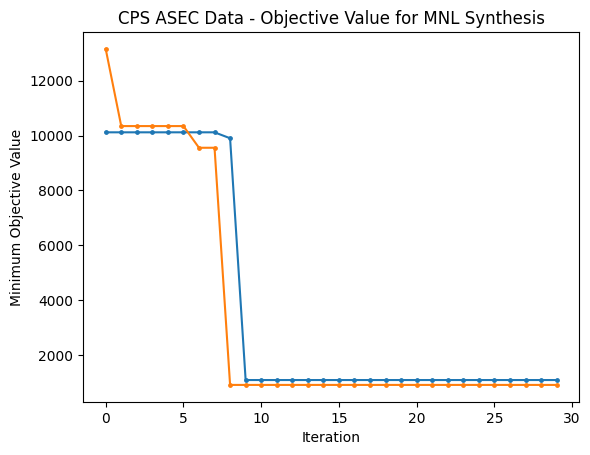

In [12]:
fig = plt.figure()
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("CPS ASEC Data - Objective Value for MNL Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
fig.savefig('../Images/min_objective_mnl_ipums.pdf')
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [10]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [11]:
best_params

{'target': -0.4240556718658755,
 'params': {'C_non_white_': 2.913536225982302,
  'C_sex_': 0.0721814178328715,
  'num_components_': 190.8550459917231}}

Generate 20 synthetic data sets.

On occassion, the synthesis models will produce a significantly different fit than what was observed during the optimization process. In these cases, retrain the models until a fit (judged by the pMSE ratio) consistent with the optimization results is observed.

In [12]:
pmse_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_non_white_=best_params['params']['C_non_white_'],
                                             C_sex_=best_params['params']['C_sex_'])

In [13]:
np.mean(pmse_ratios)

1.4601650089326772

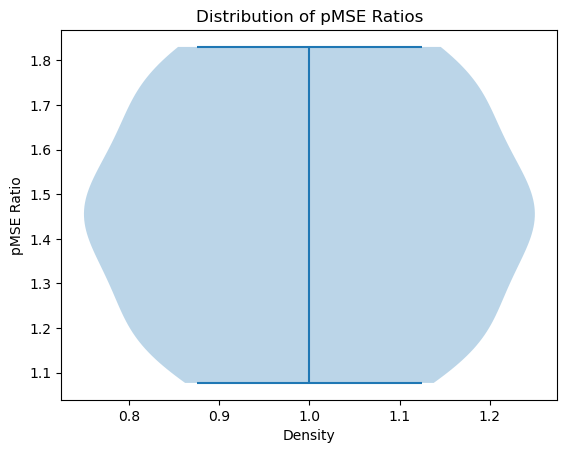

In [14]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

Save the GMM model.

In [22]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)

# save
with open('../Results/IPUMS/Models/gmm_and_mnl.pkl','wb') as f:
    pickle.dump(GMM,f)

In [10]:
# full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv") for i in range(20)]

# # load
# with open('../Results/IPUMS/Models/gmm_and_mnl.pkl', 'rb') as f:
#     GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [11]:
# prior = np.mean(train_data.non_white == 1)

In [12]:
# prior

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [13]:
# c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [14]:
# deltas = np.linspace(0.001, 0.1, 5)

In [15]:
# ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
#                                          synthetic_data=X,
#                                          continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
#                                          categorical_vars=['sex'],
#                                          sensitive_var='non_white',
#                                          num_mixture_components=190,#int(best_params['params']['num_components_']),
#                                          deltas=deltas, 
#                                          c=c, 
#                                          prior_prob=prior) for X in full_sXs]

***

In [16]:
# num_records = train_data.shape[0]

In [17]:
# np.mean([Z.shape[0] - num_records for Z in ad_sXs])

***

In [18]:
# for i, sX in enumerate(ad_sXs):
    
#     # normalize
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = StandardScaler().fit_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])

#     # convert to original scale (un-normalize?)
#     H = train_data.sample(frac=1.0, replace=True, ignore_index=True).loc[:,['incwage', 'years_of_educ', 'potential_experience']]
#     scaler = StandardScaler().fit(H.loc[:, ['incwage', 'years_of_educ', 'potential_experience']])
#     sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(sX.loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']] = scaler.inverse_transform(full_sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
#     sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_mnl_" + str(i) + ".csv", index=False)
#     full_sXs[i].to_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_mnl_" + str(i) + ".csv", index=False)